In [59]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [60]:
file_path = "C:/Users/chimc/Desktop/Thomsun Infocare/capricorn UAT data/data2024.csv"
df = pd.read_csv(file_path,  encoding='ISO-8859-1', parse_dates=["invoicedate"], index_col="invoicedate")

In [ ]:
# Remove Missing Values
df = df.drop(columns=['returndate','returnnumber'])

# Ensure data is sorted by date
df = df.sort_index()

# Aggregate sales by day
sales_data_daily = df["salesamount"].resample("D").sum()

# Smoothing with Moving Average
# Replace outliers by averaging nearby values.
sales_data_daily = sales_data_daily.rolling(window=14, center=True, min_periods=1).mean()

In [ ]:
sales_data_daily

In [68]:
# Extract date-based features
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['weekday'] = df.index.weekday
df['is_weekend'] = df['weekday'].apply(lambda x: 1 if x >= 5 else 0)

In [69]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
sales_data_scaled = scaler.fit_transform(sales_data_daily.values.reshape(-1, 1))
sales_data_scaled = pd.Series(sales_data_scaled.flatten(), index=sales_data_daily.index)

In [15]:
# ADF Test
adf_result = adfuller(sales_data_daily.dropna())

print(f"ADF Statistic: {adf_result[0]}")
print(f"P-Value: {adf_result[1]}")

if adf_result[1] > 0.05:
    print("The data is NOT stationary. Differencing is needed.")
else:
    print("The data is stationary. No differencing required.")


ADF Statistic: -2.484653608567048
P-Value: 0.11925305739510939
The data is NOT stationary. Differencing is needed.


ADF Statistic: -18.686767141939306
P-Value: 2.040410592671991e-30
The data is stationary. No differencing required.


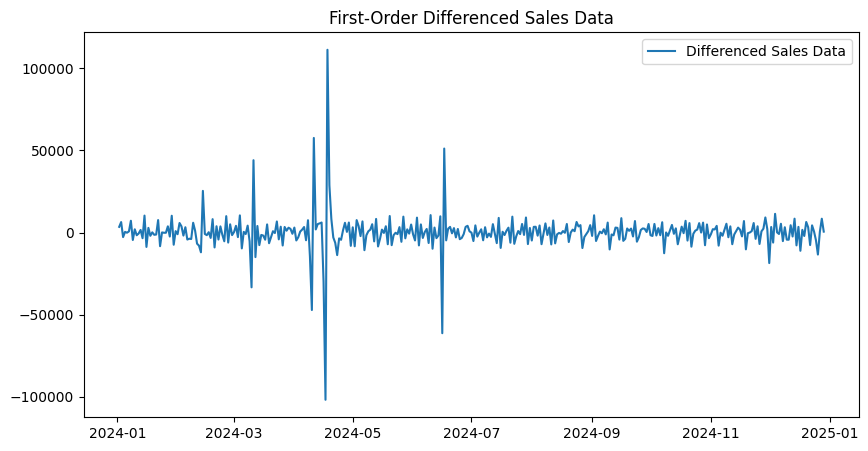

In [ ]:
#First order Differencing
sales_diff = sales_data_daily.diff().dropna()

# ADF Test
adf_result = adfuller(sales_diff.dropna())

print(f"ADF Statistic: {adf_result[0]}")
print(f"P-Value: {adf_result[1]}")

if adf_result[1] > 0.05:
    print("The data is NOT stationary. Differencing is needed.")
else:
    print("The data is stationary. No differencing required.")

# Plot the differenced series
plt.figure(figsize=(10,5))
plt.plot(sales_diff, label="Differenced Sales Data")
plt.title("First-Order Differenced Sales Data")
plt.legend()
plt.show()


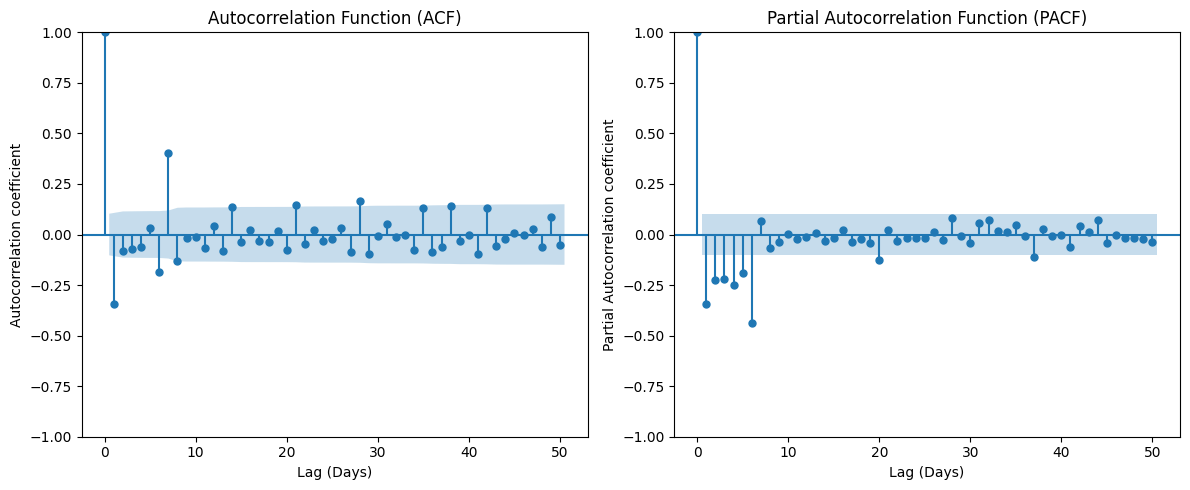

In [ ]:
#PACF ACF
# Set figure size
plt.figure(figsize=(12,5))

# ACF Plot (to determine MA(q))
plt.subplot(121)
plot_acf(sales_diff, lags=50, ax=plt.gca())  # Adjust lags based on data
plt.title("Autocorrelation Function (ACF)")
plt.xlabel("Lag (Days)") 
plt.ylabel("Autocorrelation coefficient")

# PACF Plot (to determine AR(p))
plt.subplot(122)
plot_pacf(sales_diff, lags=50, ax=plt.gca(), method='ywm')  # Using 'ywm' to avoid warnings
plt.title("Partial Autocorrelation Function (PACF)")
plt.xlabel("Lag (Days)") 
plt.ylabel("Partial Autocorrelation coefficient")

plt.tight_layout()
plt.show()


c:\Users\chimc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\chimc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\chimc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Absolute Error (MAE): 3255.13
Mean Squared Error (MSE): 20220300.90
Root Mean Squared Error (RMSE): 4496.70


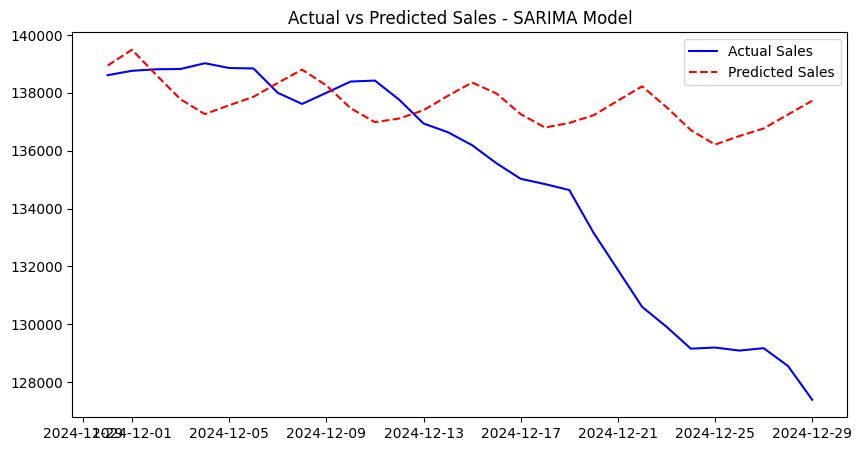

In [70]:
# Get predictions for last 30 days
test_size = 30
train = sales_data_daily[:-test_size]
test = sales_data_daily[-test_size:]

# Fit SARIMA on training data
sarima_model = SARIMAX(train, order=(6, 1, 5), seasonal_order=(6, 1, 5, 7))
sarima_result = sarima_model.fit()

# Predict last 30 days
predictions = sarima_result.predict(start=len(train), end=len(train) + test_size - 1)

# Compute error metrics
mae = mean_absolute_error(test, predictions)
mse = mean_squared_error(test, predictions)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# Plot actual vs predicted
plt.figure(figsize=(10,5))
plt.plot(test, label="Actual Sales", color='blue')
plt.plot(predictions, label="Predicted Sales", color='red', linestyle='dashed')
plt.title("Actual vs Predicted Sales - SARIMA Model")
plt.legend()
plt.show()


In [64]:
# Define SARIMA Model
sarima_model = SARIMAX(sales_data_daily, order=(2,1,2), seasonal_order=(2,1,2,7))

# Fit the model
sarima_result = sarima_model.fit()


c:\Users\chimc\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


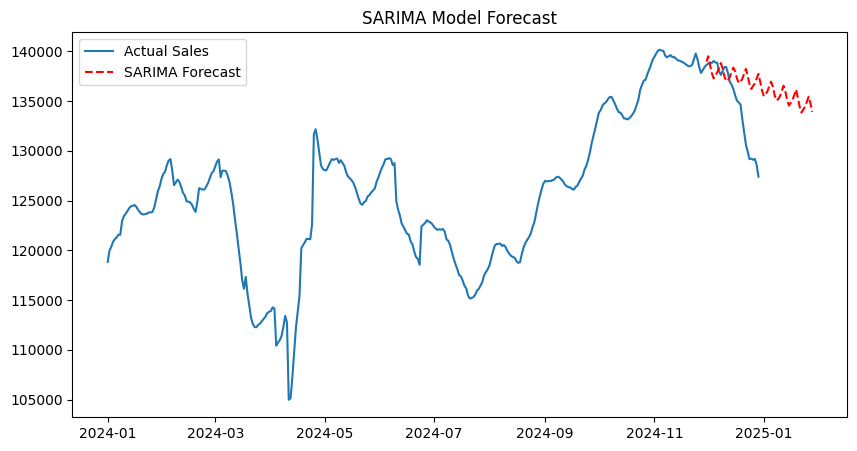

In [72]:
# Forecast the next 30 days
forecast = sarima_result.forecast(steps=60)

# Plot the forecast
plt.figure(figsize=(10,5))
plt.plot(sales_data_daily, label="Actual Sales")
plt.plot(forecast, label="SARIMA Forecast", linestyle='dashed', color='red')
plt.title("SARIMA Model Forecast")
plt.legend()
plt.show()
